✅ Success: Using Apple M4 GPU (MPS acceleration)
Epoch [100/1000], Loss: 0.4961
Epoch [200/1000], Loss: 0.4961
Epoch [300/1000], Loss: 0.4961
Epoch [400/1000], Loss: 0.4961
Epoch [500/1000], Loss: 0.4961
Epoch [600/1000], Loss: 0.4961
Epoch [700/1000], Loss: 0.4961
Epoch [800/1000], Loss: 0.4961
Epoch [900/1000], Loss: 0.4961
Epoch [1000/1000], Loss: 0.4961

--- Prediction Example (GPU Model) ---
Predicted price for a 4-bedroom, 3000 sqft house: $762,039.31


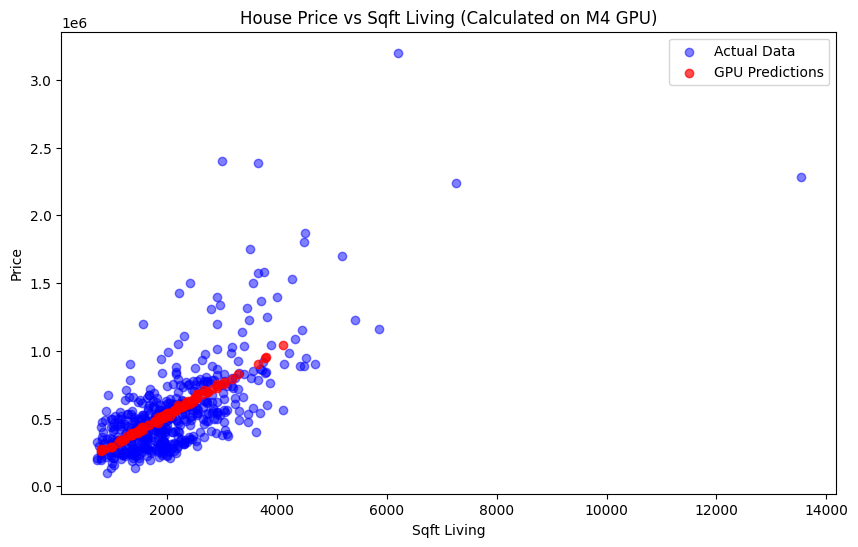

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Setup the M4 GPU (MPS)
# This checks if Apple Metal is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ Success: Using Apple M4 GPU (MPS acceleration)")
else:
    device = torch.device("cpu")
    print("⚠️ MPS not found. Using CPU instead.")

# 2. Load and Preprocess Data
filename = 'house_price_full+(2) - house_price_full+(2).csv'
data = pd.read_csv(filename)

X = data[['bedrooms', 'sqft_living']].values
y = data['price'].values.reshape(-1, 1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# CRITICAL STEP FOR GPU/NEURAL NETWORKS: Scaling
# Unlike sklearn's analytical approach, GPU gradient descent needs scaled data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

# 3. Convert to PyTorch Tensors and MOVE TO GPU
# This is where we physically send data to the M4 chip
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)

# 4. Define the Linear Regression Model
# A simple neural network with 1 layer is mathematically identical to Linear Regression
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        # 2 inputs (bedrooms, sqft) -> 1 output (price)
        self.linear = nn.Linear(2, 1) 
    
    def forward(self, x):
        return self.linear(x)

model = LinearRegressionModel().to(device) # Move model to GPU

# 5. Training Loop (Gradient Descent)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

epochs = 1000
for epoch in range(epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# 6. Evaluation (Move predictions back to CPU for plotting)
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_tensor).cpu().numpy()

# Inverse transform to get actual dollar values back
y_pred = scaler_y.inverse_transform(y_pred_scaled)

print("\n--- Prediction Example (GPU Model) ---")
# Predict for 4 bedrooms, 3000 sqft
custom_input = np.array([[4, 3000]])
custom_input_scaled = scaler_X.transform(custom_input)
custom_tensor = torch.tensor(custom_input_scaled, dtype=torch.float32).to(device)

with torch.no_grad():
    predicted_scaled = model(custom_tensor).cpu().numpy()
    predicted_price = scaler_y.inverse_transform(predicted_scaled)

print(f"Predicted price for a 4-bedroom, 3000 sqft house: ${predicted_price[0][0]:,.2f}")

# 7. Visualization
plt.figure(figsize=(10, 6))
plt.scatter(data['sqft_living'], data['price'], color='blue', alpha=0.5, label='Actual Data')

# To plot the trend line, we need to sort the test values to make a clean line
# Or simply plot the predictions vs actuals we just calculated
# Here we plot the specific test points to show fit
X_test_sqft = X_test[:, 1] # Get original sqft values
plt.scatter(X_test_sqft, y_pred, color='red', alpha=0.7, label='GPU Predictions')

plt.title('House Price vs Sqft Living (Calculated on M4 GPU)')
plt.xlabel('Sqft Living')
plt.ylabel('Price')
plt.legend()
plt.show()